Use variational autoencoder to generate Fashion MNIST images

# Load Fashion MNIST and pre-process it

In [1]:
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

def pre_process(images):
  images = images.astype('float32') / 255.0 # Pixels from 0-1

  # Pad images to 32x32
  images = np.pad(images, ((0,0),(2,2),(2,2)), constant_values=0.0)
  images = np.expand_dims(images, axis=-1)
  return images

x_train = pre_process(x_train)
x_test = pre_process(x_test)

# Encoder

Map image to point in latent space

In [3]:
encoder_input = layers.Input(shape=(32,32,1))

# Half the size of output of each layer
conv_1_layer = layers.Conv2D(filters=32, kernel_size=(3,3), strides=2, activation='relu', padding='same')(encoder_input)
conv_2_layer = layers.Conv2D(filters=64, kernel_size=(3,3), strides=2, activation='relu', padding='same')(conv_1_layer)
conv_3_layer = layers.Conv2D(filters=128, kernel_size=(3,3), strides=2, activation='relu', padding='same')(conv_2_layer)

flatten_layer = layers.Flatten()(conv_3_layer)

encoder_output = layers.Dense(2, activation='relu')(flatten_layer) # 2-D latent space

encoder = models.Model(encoder_input, encoder_output)
encoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,770 (378.01 KB)

 Trainable params: 96,770 (378.01 KB)

 Non-trainable params: 0 (0.00 B)

# Decoder

Map point in latent space to image

In [4]:
decoder_input = layers.Input(shape=(2,))

dense_layer = layers.Dense(units=4*4*128, activation='relu')(decoder_input)

reshape_layer = layers.Reshape((4,4,128))(dense_layer)

# Double size of input tensore in both dimensions to get back to original image dimension (32x32)
conv_1_layer = layers.Conv2DTranspose(filters=128, kernel_size=(3,3), strides=2, activation='relu', padding='same')(reshape_layer)
conv_2_layer = layers.Conv2DTranspose(filters=64, kernel_size=(3,3), strides=2, activation='relu', padding='same')(conv_1_layer)
conv_3_layer = layers.Conv2DTranspose(filters=32, kernel_size=(3,3), strides=2, activation='relu', padding='same')(conv_2_layer)

# Sigmoid good for reconstructing outputs 0-1
decoder_output = layers.Conv2D(filters=1, kernel_size=(3,3), strides=1, activation='sigmoid', padding='same')(conv_3_layer)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

# Autoencoder

In [5]:
autoencoder = models.Model(encoder_input, decoder(encoder_output))
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         4,098 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_1 (Functional)       │ (None, 32, 32, 1)      │       246,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 343,043 (1.31 MB)

 Trainable params: 343,043 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy') # Slightly blurrier than RMSE

## Train Model

In [7]:
autoencoder.fit(x_train, x_train, epochs=10, batch_size=128, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 0.3893 - val_loss: 0.2696
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 0.2657 - val_loss: 0.2624
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.2593 - val_loss: 0.2589
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.2570 - val_loss: 0.2585
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.2553 - val_loss: 0.2553
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.2548 - val_loss: 0.2543
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.2531 - val_loss: 0.2538
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.2516 - val_loss: 0.2527
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.2507 - val_loss: 0.2529
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.2506 - val_loss: 0.2518


## Visualize Model

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


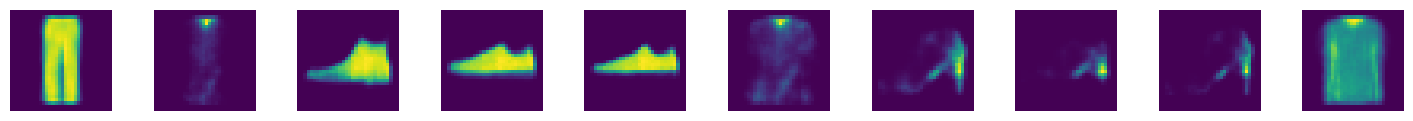

In [8]:
grid_width, grid_height = (10,3) # Grid dimensions

# 10 rows and 2 columns

embeddings = encoder.predict(x_test) # Get boundaries of latent space
mins, maxes = np.min(embeddings, axis=0), np.max(embeddings, axis=0)
sample = np.random.uniform(mins, maxes, size=(10, 2)) # Sample from latent space

reconstructions = decoder.predict(sample)

fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4) # Add space b/n images

# Display images in grid
for i in range(10):
  ax = fig.add_subplot(grid_height, grid_width, i + 1)
  ax.axis("off")
  ax.imshow(reconstructions[i, :, :]) # Display generated image w/in subset

# Variational Autoencoder

Purpose: Reduce high loss of regular autoencoder

Encoder maps each image to a normal distribution around a point in latent space.

Assume no coorelation b/n dimensions in latent space

In [9]:
class Sampling(layers.Layer):
  """
  Sample a point from a normal distribution and return it
  """
  def call(self, inputs):
    mean, log_var = inputs
    batch = tf.shape(log_var)[0]
    dim = tf.shape(log_var)[1]
    epsilon = K.random_normal(shape=(batch, dim)) # Generate random tensor from normal distribution

    # Essential for gradients to back-propagate
    return mean + tf.exp(0.5 * log_var) * epsilon # Re-parameterization formula

## Encoder

In [10]:
encoder_input = layers.Input(shape=(32,32,1))

# Half the size of output of each layer
conv_1_layer = layers.Conv2D(filters=32, kernel_size=(3,3), strides=2, activation='relu', padding='same')(encoder_input)
conv_2_layer = layers.Conv2D(filters=64, kernel_size=(3,3), strides=2, activation='relu', padding='same')(conv_1_layer)
conv_3_layer = layers.Conv2D(filters=128, kernel_size=(3,3), strides=2, activation='relu', padding='same')(conv_2_layer)

flatten_layer = layers.Flatten()(conv_3_layer)

mean = layers.Dense(2)(flatten_layer)
log_var = layers.Dense(2)(flatten_layer)

z = Sampling()([mean, log_var])

encoder = models.Model(encoder_input, [mean, log_var, z])
encoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 16,    │        320 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 8, 8, 64)  │     18,496 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 4, 4, 128) │     73,856 │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 2048)      │          0 │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │      4,098 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 2)         │      4,098 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ dense_2[0][0],    │
│                     │                   │            │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 100,868 (394.02 KB)

 Trainable params: 100,868 (394.02 KB)

 Non-trainable params: 0 (0.00 B)

## Training Model

In [11]:
class VAE(keras.Model):
  def __init__(self, encoder, decoder, **kwargs):
    """
    Use KL-divergence to see how similar encoder output is to a normal distribution
    """
    super(VAE, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder

    # Initialize metrics

    self.total_loss_tracker = keras.metrics.Mean(name='total_loss')

    # Make sure output matches original input
    self.reconstruction_loss_tracker = keras.metrics.Mean(name='reconstruction_loss')

    self.kl_loss_tracker = keras.metrics.Mean(name='kl_loss')

  @property
  def metrics(self):
    return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker
    ]

  def call(self, inputs):
    """
    Forward pass of model
    """
    mean, log_var, z = self.encoder(inputs)
    reconstruction = self.decoder(z)
    return mean, log_var, reconstruction

  def train_step(self, data):
    """
    Single training step
    """
    with tf.GradientTape() as tape: # Allow computing gradients during foeward pass
      z_mean, z_log_var, reconstruction = self(data)

      reconstruction_loss = tf.reduce_mean(tf.square(data - reconstruction))

      kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
      kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

      total_loss = reconstruction_loss + kl_loss

    grads = tape.gradient(total_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

    self.total_loss_tracker.update_state(total_loss)
    self.reconstruction_loss_tracker.update_state(reconstruction_loss)
    self.kl_loss_tracker.update_state(kl_loss)

    return {
        'loss': self.total_loss_tracker.result(),
        'reconstruction_loss': self.reconstruction_loss_tracker.result(),
        'kl_loss': self.kl_loss_tracker.result()
    }

In [12]:
vae_model = VAE(encoder, decoder)
vae_model.compile(optimizer=keras.optimizers.Adam())
vae_model.fit(x_train, epochs=10, batch_size=100)

Epoch 1/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - kl_loss: 1.1501e-04 - loss: 0.0723 - reconstruction_loss: 0.0722
Epoch 2/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - kl_loss: 7.4323e-08 - loss: 0.0668 - reconstruction_loss: 0.0668
Epoch 3/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - kl_loss: 3.2753e-08 - loss: 0.0669 - reconstruction_loss: 0.0669
Epoch 4/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - kl_loss: 2.3674e-08 - loss: 0.0667 - reconstruction_loss: 0.0667
Epoch 5/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - kl_loss: 2.3811e-08 - loss: 0.0669 - reconstruction_loss: 0.0669
Epoch 6/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - kl_loss: 1.7520e-08 - loss: 0.0667 - reconstruction_loss: 0.0667
Epoch 7/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - kl_loss: 1.1064e-08 - loss: 0.0666 - reconstruction_loss: 0.0666
Epoch 8/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - kl_loss: 1.6421e-08 - loss: 0.0668 - reconstruction_loss: 0.0668
Epoch 9/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/

## Visualize Model Output

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


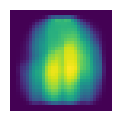

In [18]:
grid_width, grid_height = (10,3) # Grid dimensions

# 1 row and 2 columns
sample = np.random.normal(size=(1, 2)) # Random sample from latent space

reconstructions = decoder.predict(sample)

fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4) # Add space b/n images

# Display images in grid
for i in range(1):
  ax = fig.add_subplot(grid_height, grid_width, i + 1)
  ax.axis("off")
  ax.imshow(reconstructions[i, :, :]) # Display generated image w/in subset

## Save Model

In [19]:
vae_model.save('vae_fashion_mnist.keras')